In [5]:
%pip install pandas
%pip install scikit-learn
%pip install plotly
%pip install numpy
%pip install matplotlib
%pip install nbformat
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached jsonschema-4.21.1-py3-none-any.whl.metadata (7.8 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached jsonschema_specifications-2023.12.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.34.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached rpds_py-0.18.0-cp310-none-win_amd64.whl.metadata (4.2 kB)
   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   ---------------------------------------- 78.5/78.5 kB 2.2 MB/s eta 0:00:00
Using cached jsonschema-4.21.1-py3-none-any.whl (85 kB)
Using cached attrs-23.2.0-py3-none-any.whl (60 kB)
Using cached jsonschema_specifications-2023.12.1-py3-non

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import plotly.express as px
from sklearn.model_selection import train_test_split
import random


In [2]:
emotion_labels = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral",
}

print(emotion_labels)

{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


In [4]:
fer2013_df = pd.read_csv("../../data/raw/fer2013.csv", index_col=False)
fer2013_df.drop(columns="Usage", inplace=True)

fer2013_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
train_ratio = 0.80
test_ratio = 0.10
validation_ratio = 0.10

X = fer2013_df["pixels"].values
y = fer2013_df["emotion"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=validation_ratio / (train_ratio + test_ratio)
)

print(len(X_train))
print(len(X_test))
print(len(X_valid))

28709
3589
3589


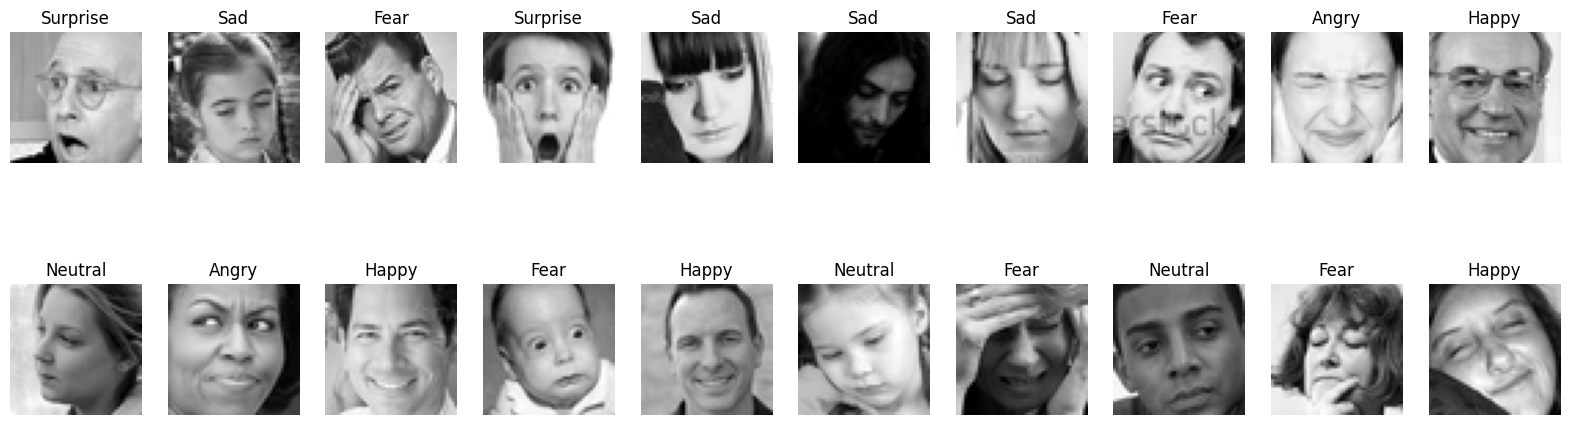

In [15]:


random.seed(42)
random_numbers = [random.randint(0, len(X_train)) for _ in range(20)]

img_list = []
img_labels = []
for idx in random_numbers:
    image_string = X_train[idx].split(" ")
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48, 48)
    img = Image.fromarray(image_data)
    img_list.append(img)
    img_labels.append(y_train[idx])


fig, ax = plt.subplots(2, 10, figsize=(20, 6))
for i, img in enumerate(img_list):
    row, col = divmod(i, 10)
    ax[row, col].imshow(img, cmap="gray")
    ax[row, col].axis("off")
    ax[row, col].set_title(emotion_labels.get(img_labels[i]))

plt.show()

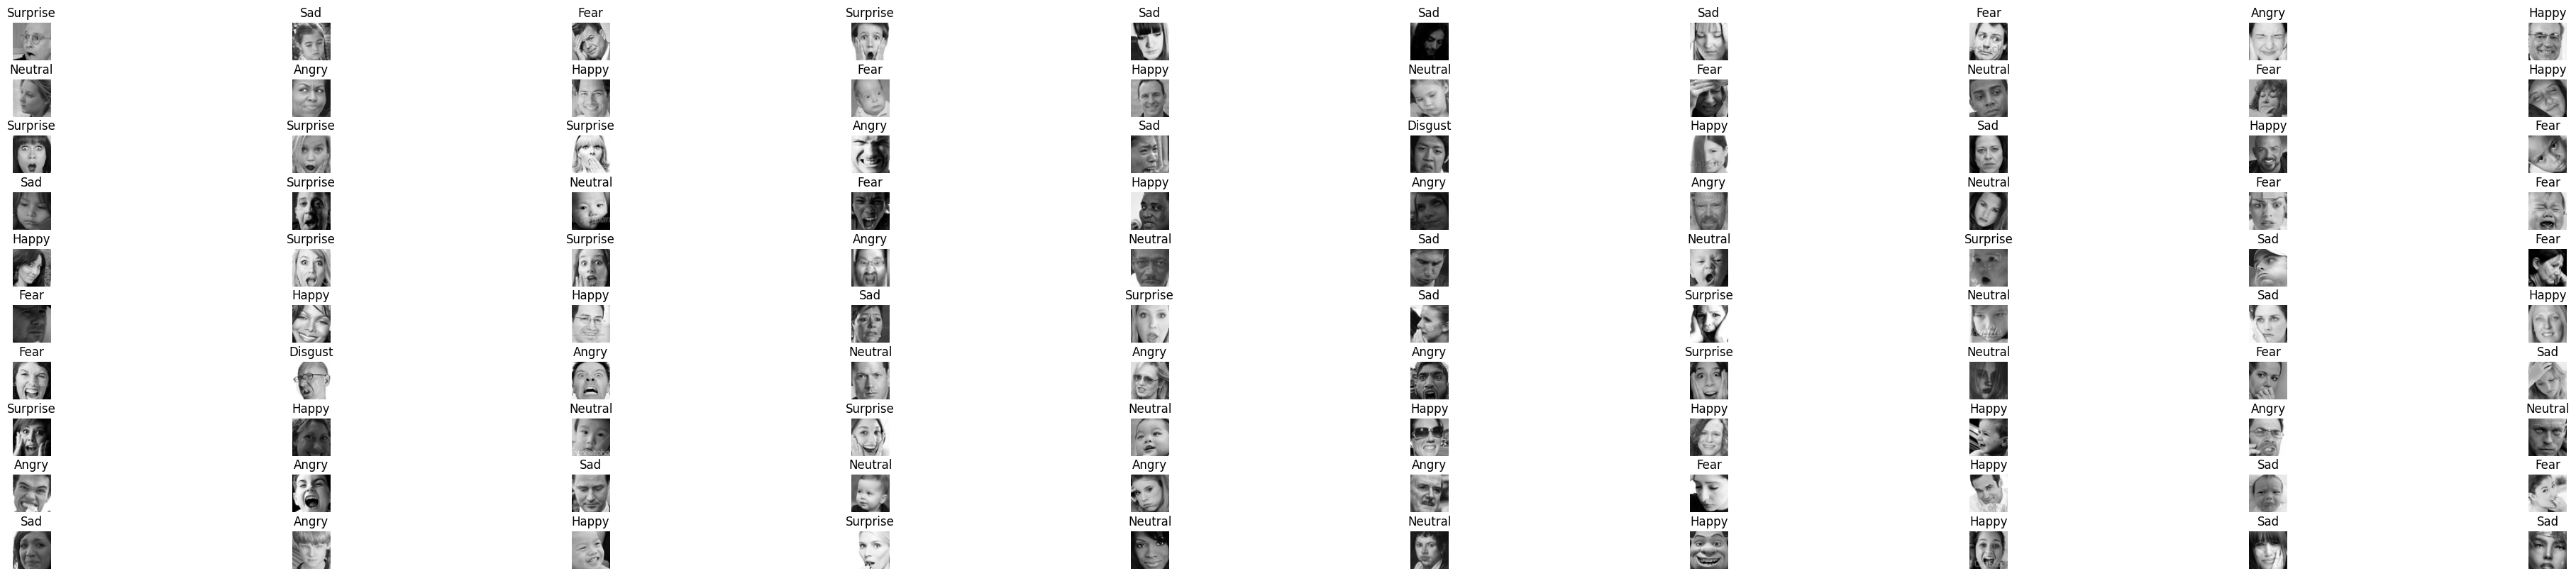

In [14]:
# Look at a hunded Pictures to evaluate how good the data is labelled.

import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(42)
random_numbers = [random.randint(0, len(X_train)) for _ in range(100)]

img_list = []
img_labels = []
for idx in random_numbers:
    image_string = X_train[idx].split(" ")
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48, 48)
    img = cv2.cvtColor(image_data, cv2.COLOR_GRAY2BGR)
    img_list.append(img)
    img_labels.append(y_train[idx])

fig, ax = plt.subplots(10, 10, figsize=(50, 10))
plt.subplots_adjust(hspace=0.5)
for i, img in enumerate(img_list):
    row, col = divmod(i, 10)
    ax[row, col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[row, col].axis("off")
    ax[row, col].set_title(emotion_labels.get(img_labels[i]))

plt.show()

In [19]:
label_counts = {label: np.sum(y_train == label) for label in np.unique(y_train)}

labels = {}
for key, value in label_counts.items():
    labels[emotion_labels.get(key)] = value

In [17]:
fig = px.bar(x=list(labels.keys()), y=list(labels.values()), color=list(labels.keys()))

fig.update_layout(
    title="Total images for each label in training set",
    xaxis_title="Emotion",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [22]:
label_counts_all = {label: np.sum(y == label) for label in np.unique(y)}

labels_all = {}
for key, value in label_counts_all.items():
    labels_all[emotion_labels.get(key)] = value

In [24]:
fig = px.bar(x=list(labels_all.keys()), y=list(labels_all.values()), color=list(labels_all.keys()))

fig.update_layout(
    title="Total images for each label in data set",
    xaxis_title="Emotion",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()